## Procesamiento de Lenguaje Natural
### Proyecto final - Clickbait Detection

#### Segunda parte - Tokenización.

Se cargan los archivos de la división de datos:
- `TA1C_dataset_detection_train_split.csv` → contiene el conjunto de entrenamiento (75%).
- `TA1C_dataset_detection_dev_split.csv` → contiene el conjunto de desarrollo (25%).

E importan librerias.

In [13]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Carga del conjunto de entrenamiento y desarrollo

En esta sección se leen los archivos:

- `TA1C_dataset_detection_train_split.csv` (75% de los datos)
- `TA1C_dataset_detection_dev_split.csv` (25% de los datos)

y se guardan en los `DataFrame` `df_train` y `df_dev`.

Las columnas que nos interesan son:

- **`Teaser Text`**: texto breve de la noticia (entrada del modelo).
- **`Tag Value`**: etiqueta original de la clase (`Clickbait` o `No`).

Al final se muestran las primeras filas y el conteo de cada clase para verificar que la lectura se hizo correctamente.

In [14]:
# Rutas a los archivos
train_path = "TA1C_dataset_detection_train_split.csv"  # 75%
dev_path   = "TA1C_dataset_detection_dev_split.csv"    # 25%

TEXT_COL  = "Teaser Text"   # columna con el texto
LABEL_COL = "Tag Value"  # columna con la etiqueta

df_train = pd.read_csv(train_path)
df_dev   = pd.read_csv(dev_path)

print(df_train.head())
print(df_train[LABEL_COL].value_counts())

                                         Teaser Text  Tag Value
0  la letra que ha dejado sin bote a pablo díaz e...  Clickbait
1  sanidad revende 30.000 dosis de la vacuna cont...         No
2  video. putin presume nuevo armamento nuclear r...         No
3  salvador cienfuegos, el general que nadie se a...         No
4  conocimiento mundial ¿cuál es el nivel de la i...  Clickbait
Tag Value
No           1502
Clickbait     598
Name: count, dtype: int64


Distribución de clases en el conjunto de entrenamiento

Aquí se genera un gráfico de barras con la distribución de la variable
**`Tag Value`** en `df_train`.

- El eje *x* muestra las clases (`Clickbait`, `No`).
- El eje *y* muestra el número de ejemplos en cada clase.

Esta visualización permite observar que la clase `Clickbait` es minoritaria
frente a `No`, lo cual nos indica que el problema presenta cierto desbalance
de clases.

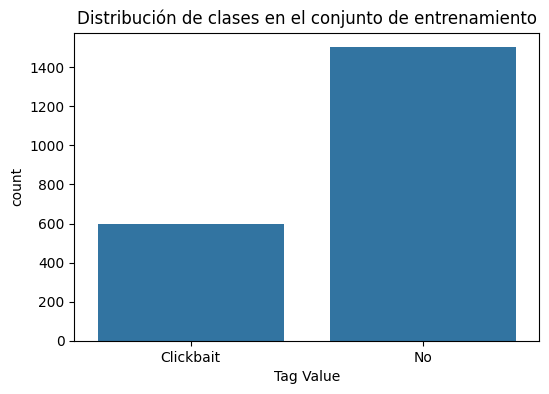

In [15]:
fig, ax = plt.subplots(figsize=(6,4))
sns.countplot(x=LABEL_COL, data=df_train, ax=ax)
ax.set_title("Distribución de clases en el conjunto de entrenamiento")
plt.show()

Mapeo de las etiquetas de texto a valores numéricos

Los modelos de clasificación de HuggingFace trabajan con etiquetas numéricas.
En este bloque se realiza el mapeo explícito:

- `No` → `0`
- `Clickbait` → `1`

Se crea una nueva columna llamada **`label_id`** en `df_train` y `df_dev`,
que contiene estos valores numéricos.  
También se definen los diccionarios `label2id` e `id2label` para mantener el
mapeo entre IDs y nombres de las clases, lo cual será útil al configurar
el modelo de BERT.

Finalmente, se muestran algunas filas de ejemplo y el conteo de cada `label_id`
para comprobar que el mapeo se realizó correctamente.

In [16]:
label2id = {"No": 0, "Clickbait": 1}
id2label = {0: "No", 1: "Clickbait"}

df_train["label_id"] = df_train[LABEL_COL].map(label2id)
df_dev["label_id"]   = df_dev[LABEL_COL].map(label2id)

LABEL_ID_COL = "label_id"

print(df_train[[TEXT_COL, LABEL_COL, LABEL_ID_COL]].head())
print(df_train[LABEL_ID_COL].value_counts())

                                         Teaser Text  Tag Value  label_id
0  la letra que ha dejado sin bote a pablo díaz e...  Clickbait         1
1  sanidad revende 30.000 dosis de la vacuna cont...         No         0
2  video. putin presume nuevo armamento nuclear r...         No         0
3  salvador cienfuegos, el general que nadie se a...         No         0
4  conocimiento mundial ¿cuál es el nivel de la i...  Clickbait         1
label_id
0    1502
1     598
Name: count, dtype: int64


Creación de los conjuntos `Dataset` de HuggingFace

En esta sección se convierten los `DataFrame` de pandas (`df_train` y `df_dev`) al formato
`Dataset` de la librería **HuggingFace Datasets**, que es el que espera el `Trainer`.

- Solo se conservan dos columnas:  
  - `Teaser Text` → texto de la noticia (entrada del modelo).  
  - `label_id` → etiqueta numérica (`0` = No, `1` = Clickbait).
- Después se renombra la columna `label_id` a `labels`, que es el nombre estándar que
  utiliza HuggingFace para identificar la variable objetivo en tareas de clasificación.

De esta forma quedan definidos `train_ds` y `dev_ds` como conjuntos de entrenamiento y
desarrollo listos para ser tokenizados.

In [17]:
train_ds = Dataset.from_pandas(df_train[[TEXT_COL, LABEL_ID_COL]])
dev_ds   = Dataset.from_pandas(df_dev[[TEXT_COL, LABEL_ID_COL]])

train_ds = train_ds.rename_column(LABEL_ID_COL, "labels")
dev_ds   = dev_ds.rename_column(LABEL_ID_COL, "labels")

Configuración del *tokenizer* y tokenización de los conjuntos

En esta parte se configura el *tokenizer* del modelo **BERT en español**  
`dccuchile/bert-base-spanish-wwm-cased` y se aplica sobre los textos:

- Se carga el `BertTokenizer` preentrenado a partir del nombre del modelo.
- Se define una longitud máxima de secuencia (`MAX_LEN = 128`), para que todas las
  entradas tengan el mismo tamaño.
- La función `tokenize_function`:
  - Toma la columna `Teaser Text` de cada ejemplo.
  - Aplica `padding="max_length"` para rellenar hasta 128 tokens.
  - Aplica `truncation=True` para recortar textos más largos.
- Finalmente, se tokenizan `train_ds` y `dev_ds` usando `map`, obteniendo
  `train_tokenized` y `dev_tokenized`, y se elimina la columna de texto original
  porque el modelo solo necesita los IDs de los tokens y las máscaras de atención.


In [18]:
MODEL_NAME = "dccuchile/bert-base-spanish-wwm-cased"
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

MAX_LEN = 128  # o 256 si tu profe lo pidió así

def tokenize_function(examples):
    return tokenizer(
        examples[TEXT_COL],
        padding="max_length",
        truncation=True,
        max_length=MAX_LEN
    )

train_tokenized = train_ds.map(tokenize_function, batched=True)
dev_tokenized   = dev_ds.map(tokenize_function, batched=True)

# Opcional: ya no necesitamos el texto para el modelo
train_tokenized = train_tokenized.remove_columns([TEXT_COL])
dev_tokenized   = dev_tokenized.remove_columns([TEXT_COL])

train_tokenized.set_format("torch")
dev_tokenized.set_format("torch")

# Checar una muestra
print(train_tokenized[0].keys())

Map: 100%|██████████| 700/700 [00:00<00:00, 1418.42 examples/s]

dict_keys(['labels', 'input_ids', 'token_type_ids', 'attention_mask'])


Definición del modelo BERT y configuración del `Trainer` (baseline)

En esta sección se define el modelo de clasificación basado en
`dccuchile/bert-base-spanish-wwm-cased` y se configura el objeto `Trainer`
de HuggingFace que centraliza el proceso de entrenamiento y evaluación.

1. **Modelo de clasificación**  
   - Se utiliza `BertForSequenceClassification`, que añade una capa lineal
     de clasificación sobre BERT.
   - Se especifica `num_labels = 2` para las dos clases del problema:
     `No` (0) y `Clickbait` (1).
   - Los diccionarios `id2label` y `label2id` permiten que el modelo mantenga
     el mapeo entre IDs numéricos y nombres de las clases.

2. **Métricas de evaluación**  
   - La función `compute_metrics` calcula:
     - `accuracy`
     - `f1_macro`
     - `precision_macro`
     - `recall_macro`
   - Se usa el promedio *macro* para que ambas clases tengan el mismo peso,
     lo cual es importante debido al desbalance entre `No` y `Clickbait`.

3. **Parámetros básicos de entrenamiento (`TrainingArguments`)**  
   - `output_dir`: carpeta donde se guardarían los resultados del modelo.
   - `num_train_epochs = 3`: número de épocas del baseline.
   - `per_device_train_batch_size` y `per_device_eval_batch_size`: tamaño
     de lote para entrenamiento y evaluación.
   - `learning_rate` y `weight_decay`: hiperparámetros estándar para modelos
     BERT en clasificación de texto.

4. **Definición del `Trainer`**  
   - Se pasa el modelo, los argumentos de entrenamiento, los conjuntos
     tokenizados (`train_tokenized`, `dev_tokenized`), el tokenizer y la
     función de métricas.
   - Aunque el `Trainer` queda totalmente configurado, en esta práctica no
     se ejecuta el entrenamiento (`trainer.train()`), ya que el objetivo del
     integrante 2 es dejar lista la tokenización y la configuración del
     modelo baseline.


In [21]:
num_labels = 2

model = BertForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id
)

def compute_metrics(pred):
    logits, labels = pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1_macro": f1_score(labels, preds, average="macro"),
        "precision_macro": precision_score(labels, preds, average="macro"),
        "recall_macro": recall_score(labels, preds, average="macro"),
    }

# >>> OJO: TrainingArguments simplificado, sin evaluation_strategy ni save_strategy <<<
training_args = TrainingArguments(
    output_dir="./bert_baseline_detection",
    num_train_epochs=3,             # baseline de 3 épocas
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    weight_decay=0.01,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=dev_tokenized,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\angel\AppData\Local\Temp\ipykernel_35712\2884896061.py:30: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Guardado de los conjuntos tokenizados

Una vez tokenizados los conjuntos de entrenamiento y desarrollo
(`train_tokenized` y `dev_tokenized`), se guardan en disco usando
`save_to_disk`:

- `train_tokenized_clickbait/`
- `dev_tokenized_clickbait/`

Estos directorios contienen los objetos `Dataset` ya procesados
(`input_ids`, `attention_mask`, `labels`), listos para ser cargados
posteriormente con `load_from_disk` y utilizados directamente en el
entrenamiento del modelo, sin necesidad de volver a tokenizar.


In [22]:
train_tokenized.save_to_disk("train_tokenized_clickbait")
dev_tokenized.save_to_disk("dev_tokenized_clickbait")

Saving the dataset (1/1 shards): 100%|██████████| 700/700 [00:00<00:00, 39027.15 examples/s]


Para cargar los conjuntos tokenizados:
Los conjuntos tokenizados de entrenamiento y desarrollo se guardaron
previamente con:

- `train_tokenized.save_to_disk("train_tokenized_clickbait")`
- `dev_tokenized.save_to_disk("dev_tokenized_clickbait")`

Para reutilizarlos en otro notebook o en una etapa posterior (por ejemplo,
para entrenar el modelo), basta con cargarlos usando `load_from_disk`:

```python
from datasets import load_from_disk

# Cargar los datasets tokenizados
train_tokenized = load_from_disk("train_tokenized_clickbait")
dev_tokenized   = load_from_disk("dev_tokenized_clickbait")

# Inspeccionar un ejemplo
print(train_tokenized[0])
print(train_tokenized.column_names)
